In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
os.environ["SM_FRAMEWORK"] = "tf.keras"
!pip install segmentation_models
import segmentation_models as sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.0 MB/s eta 0:00:00
Segmentation Models: using `tf.keras` framework.


In [17]:
def visualize_results_hc(input_dir, ground_truth_dir, output_dir, num_samples=5):
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))
    
    predicted_files = sorted(os.listdir(output_dir))[:num_samples]
    ground_truth_files = sorted(os.listdir(ground_truth_dir))[:num_samples]
    input_files = sorted(os.listdir(input_dir))[:num_samples]

    for i in range(num_samples):
        img = cv2.imread(os.path.join(input_dir, input_files[i]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        true_mask = cv2.imread(os.path.join(ground_truth_dir, ground_truth_files[i]), cv2.IMREAD_GRAYSCALE)
        pred_mask = cv2.imread(os.path.join(output_dir, predicted_files[i]), cv2.IMREAD_GRAYSCALE)

        # Display original image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        # Display ground truth mask
        axes[i, 1].imshow(true_mask, cmap="gray")
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis("off")

        # Display predicted mask
        axes[i, 2].imshow(pred_mask, cmap="gray")
        axes[i, 2].set_title("Predicted Mask (Handcrafted)")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

In [4]:
# This function segments a face image by thresholding, detecting edges, and refining the mask using morphological operations.
def segment_mask(face_img):
    gray = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)
    mean_intensity = np.mean(gray)

    if mean_intensity > 127:
        threshold_type = cv2.THRESH_BINARY
    else:
        threshold_type = cv2.THRESH_BINARY_INV 
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    _, binary_mask = cv2.threshold(blurred, 0, 255, threshold_type + cv2.THRESH_OTSU)
    edges = cv2.Canny(blurred, 225, 250)
    combined = cv2.bitwise_or(binary_mask, edges)
    kernel = np.ones((3, 3), np.uint8)
    refined_mask = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel, iterations=2)

    return refined_mask



In [5]:
#Loading the required directories
input_dir = "/kaggle/input/cddataset/MSFD/1/face_crop"  
output_dir = "/kaggle/working/MFSD/1/segmented_mask" 
ground_truth_dir = "/kaggle/input/cddataset/MSFD/1/face_crop_segmentation"  

os.makedirs(output_dir, exist_ok=True)

In [6]:
# Processes all images in input_dir, applies segmentation, and saves the results in output_dir.  
for filename in os.listdir(input_dir):
    input_path = os.path.join(input_dir, filename)
    output_path = os.path.join(output_dir, f"segmented_{filename}")

    face_img = cv2.imread(input_path)
    if face_img is None:
        print(f"Skipping unreadable file: {filename}")
        continue 

    segmented_mask = segment_mask(face_img)

    cv2.imwrite(output_path, segmented_mask)

    
print("Segmentation complete for all images.")

Segmentation complete for all images.


In [8]:
# Computes the Dice coefficient to measure the similarity between two binary masks.  
def dice_coefficient(mask1, mask2):
    mask2 = cv2.resize(mask2, (mask1.shape[1], mask1.shape[0]), interpolation=cv2.INTER_NEAREST)
    mask1 = mask1.astype(np.bool_)
    mask2 = mask2.astype(np.bool_)

    intersection = np.logical_and(mask1, mask2).sum()
    dice = (2. * intersection) / (mask1.sum() + mask2.sum() + 1e-6)  # Avoid division by zero
    return dice


In [9]:
predicted_files = sorted(os.listdir(output_dir))
ground_truth_files = sorted(os.listdir(ground_truth_dir))


assert len(predicted_files) == len(ground_truth_files), "Mismatch in file counts!"


dice_scores = []

# Computes the Dice coefficient for each predicted mask against its ground truth and stores the scores.  
for pred_file, gt_file in zip(predicted_files, ground_truth_files):
    pred_path = os.path.join(output_dir, pred_file)
    gt_path = os.path.join(ground_truth_dir, gt_file)


    pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

    if pred_mask is None or gt_mask is None:
        print(f"Skipping: {pred_file} or {gt_file} could not be loaded.")
        continue


    pred_mask = (pred_mask > 127).astype(np.uint8)
    gt_mask = (gt_mask > 127).astype(np.uint8)


    dice = dice_coefficient(pred_mask, gt_mask)
    dice_scores.append(dice)

   

average_dice = np.mean(dice_scores) if dice_scores else 0
print(f"\nAverage Dice Coefficient: {average_dice:.4f}")


Average Dice Coefficient: 0.4608


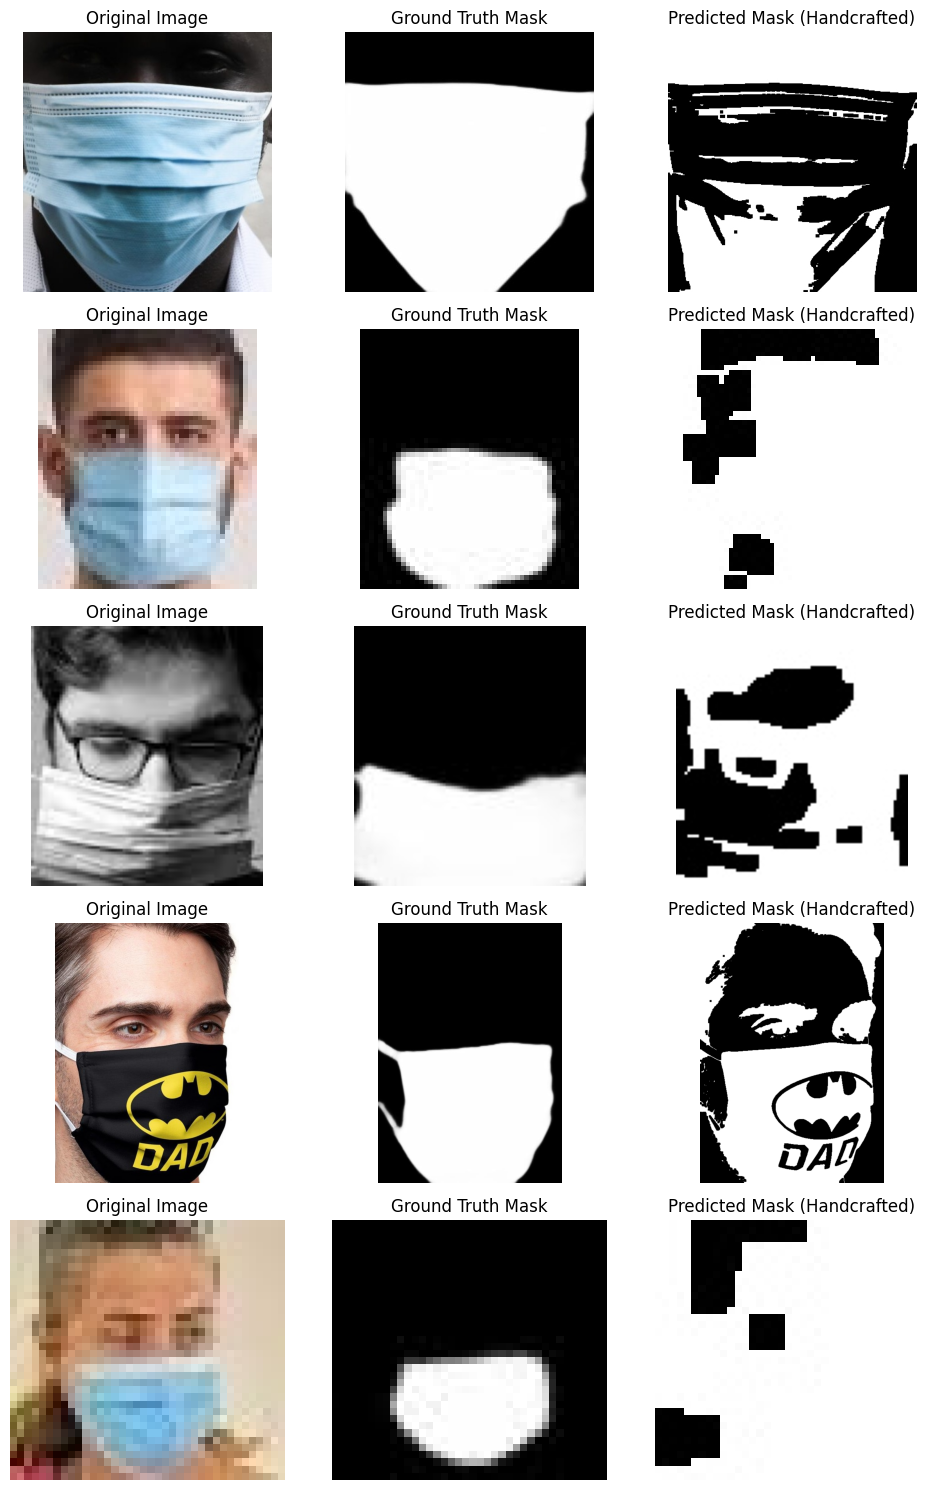

In [18]:
# Load data
#images, masks = load_images_masks(input_dir, ground_truth_dir, output_dir, num_samples=5)

# Call your function
visualize_results_hc(input_dir, ground_truth_dir, output_dir, num_samples=5)


In [20]:
# Load images and masks
def load_data(image_folder, mask_folder):
    images, masks = [], []
    image_filenames = sorted(os.listdir(image_folder))

    for filename in image_filenames:
        img_path = os.path.join(image_folder, filename)
        mask_path = os.path.join(mask_folder, filename)

        if os.path.exists(mask_path):
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Resize with nearest neighbor interpolation for masks
            img = cv2.resize(img, (128, 128)) / 255.0
            mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)
            
            # Binarize mask after resizing
            _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
            mask = mask / 255.0

            images.append(img)
            masks.append(mask)

    return np.array(images), np.array(masks)

In [21]:
X, Y = load_data(input_dir, ground_truth_dir)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.8, random_state=42)

In [22]:
# Set backbone and define U-Net
BACKBONE = "resnet50"  # You can also try "efficientnetb0", "vgg16", etc.
pretrained_unet = sm.Unet(BACKBONE, encoder_weights="imagenet", input_shape=(128, 128, 3), classes=1, activation="sigmoid")

# Compile the model
pretrained_unet.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
pretrained_unet.fit(X_train, Y_train, validation_split=0.2, epochs=10, batch_size=8)



94592056/94592056 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 103s 240ms/step - accuracy: 0.8856 - loss: 0.2764 - val_accuracy: 0.8407 - val_loss: 0.7140
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.9544 - loss: 0.1203 - val_accuracy: 0.6789 - val_loss: 0.7964
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.9672 - loss: 0.0874 - val_accuracy: 0.6800 - val_loss: 1.1331
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.9695 - loss: 0.0825 - val_accuracy: 0.8708 - val_loss: 0.4521
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.9698 - loss: 0.0792 - val_accuracy: 0.9552 - val_loss: 0.1108
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.9756 - loss: 0.0635 - val_accuracy: 0.9653 - val_loss: 0.0940
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.9756 - loss: 0.0630 - val_accuracy: 0.9618 - val_loss: 0.1133
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━

In [23]:
# Evaluate Unet Segmentation
def evaluate_unet(model, images, masks):
    pred_masks = model.predict(images)
    iou_scores, dice_scores = [], []

    for pred_mask, true_mask in zip(pred_masks, masks):
        # Remove channel dimension and binarize
        pred_mask = (pred_mask.squeeze() > 0.5).astype(np.uint8)
        true_mask = (true_mask > 0.5).astype(np.uint8)

        intersection = np.logical_and(pred_mask, true_mask).sum()
        union = np.logical_or(pred_mask, true_mask).sum()

        iou = intersection / (union + 1e-6)
        dice = (2. * intersection) / (pred_mask.sum() + true_mask.sum() + 1e-6)

        iou_scores.append(iou)
        dice_scores.append(dice)

    print(f"Pretrained U-Net - IoU: {np.mean(iou_scores):.4f}, Dice: {np.mean(dice_scores):.4f}")


In [24]:
def visualize_results(model, images, masks, num_samples=5):
    pred_masks = model.predict(images) > 0.5

    fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))

    for i in range(num_samples):
        img = (images[i] * 255).astype(np.uint8)
        true_mask = (masks[i] * 255).astype(np.uint8)
        pred_mask = (pred_masks[i] * 255).astype(np.uint8).squeeze()  # Squeeze to remove extra dimension

        # Plot original image
        axes[i, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert to RGB for proper visualization
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        # Plot ground truth mask
        axes[i, 1].imshow(true_mask, cmap="gray")
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis("off")

        # Plot predicted mask
        axes[i, 2].imshow(pred_mask, cmap="gray")
        axes[i, 2].set_title("Predicted Mask(U-Net)")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


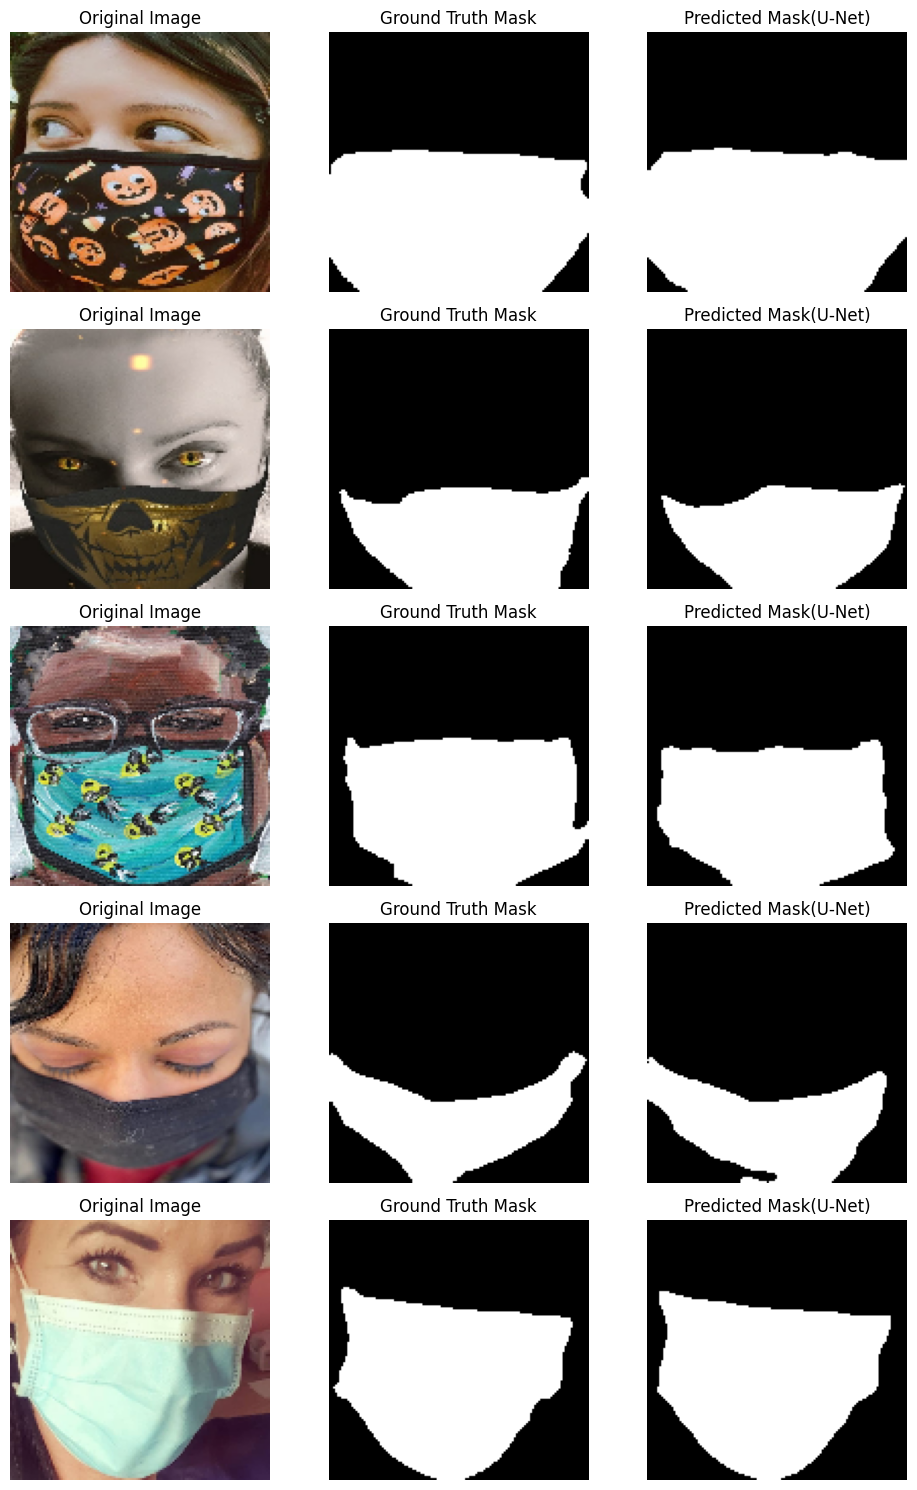

235/235 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step
Pretrained U-Net - IoU: 0.8862, Dice: 0.9329


In [25]:
visualize_results(pretrained_unet, X_test[:5], Y_test[:5])

evaluate_unet(pretrained_unet, X_test, Y_test)